In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb import *

# Load LUHMES data

In [2]:
# load data:
# perturbation info
my_conditioner = pd.read_csv('./data/LUHMES_data/LUHMES_perturbation_mat.csv')
my_conditioner = my_conditioner.drop('Nontargeting', axis=1)  # TODO: or retaining it
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

# observed expression
my_observation = pd.read_csv('./data/LUHMES_data/LUHMES_dev_filtered_raw.csv')
print(my_observation.shape)
gene_name = list(my_observation.columns)
my_observation = torch.tensor(my_observation.to_numpy() * 1.0, dtype=torch.float)

# gene names
gene_name_lookup = pd.read_csv('./data/LUHMES_data/LUHMES_unfiltered_gene_lookup.csv', index_col=0)
gene_name_lookup = {gene_name_lookup.iloc[i].unfiltered_genes: gene_name_lookup.iloc[i].feature_name_lookup_unfiltered for i in range(gene_name_lookup.shape[0])}
gene_name = [gene_name_lookup[i] for i in gene_name]

# cell level info
my_cell_info = pd.read_csv('./data/LUHMES_data/LUHMES_cell_information.csv', index_col=0)
my_cell_info = my_cell_info[['lib_size', 'batch', 'umi_count', 'percent_mt']]
my_cell_info.batch = pd.factorize(my_cell_info.batch)[0]
my_cell_info.umi_count = my_cell_info.umi_count/my_cell_info.lib_size
my_cell_info.lib_size = np.log(my_cell_info.lib_size)
cell_info_names = list(my_cell_info.columns)
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)

(8708, 6000)


# Specify and train Gaussian GPerturb

In [3]:
# specify model architecture
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 700  
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]
tau = torch.tensor(1.).to(device)  # Gumble softmax hyperparameter
top = 30
threshold = 0.95

# define the Gaussian GPerturb model
parametric_model = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                                     data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                     hidden_layer_2=hidden_layer, tau=tau)
parametric_model = parametric_model.to(device)
# train the model from scratch
parametric_model.GPerturb_train(epoch=200, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, device=device)

# load pre-trained GPerturb model
# parametric_model.load_state_dict(torch.load('GPerturb_LUHMES_Gaussian_ref_3.pt'))

<All keys matched successfully>

# Fig 3 upper half

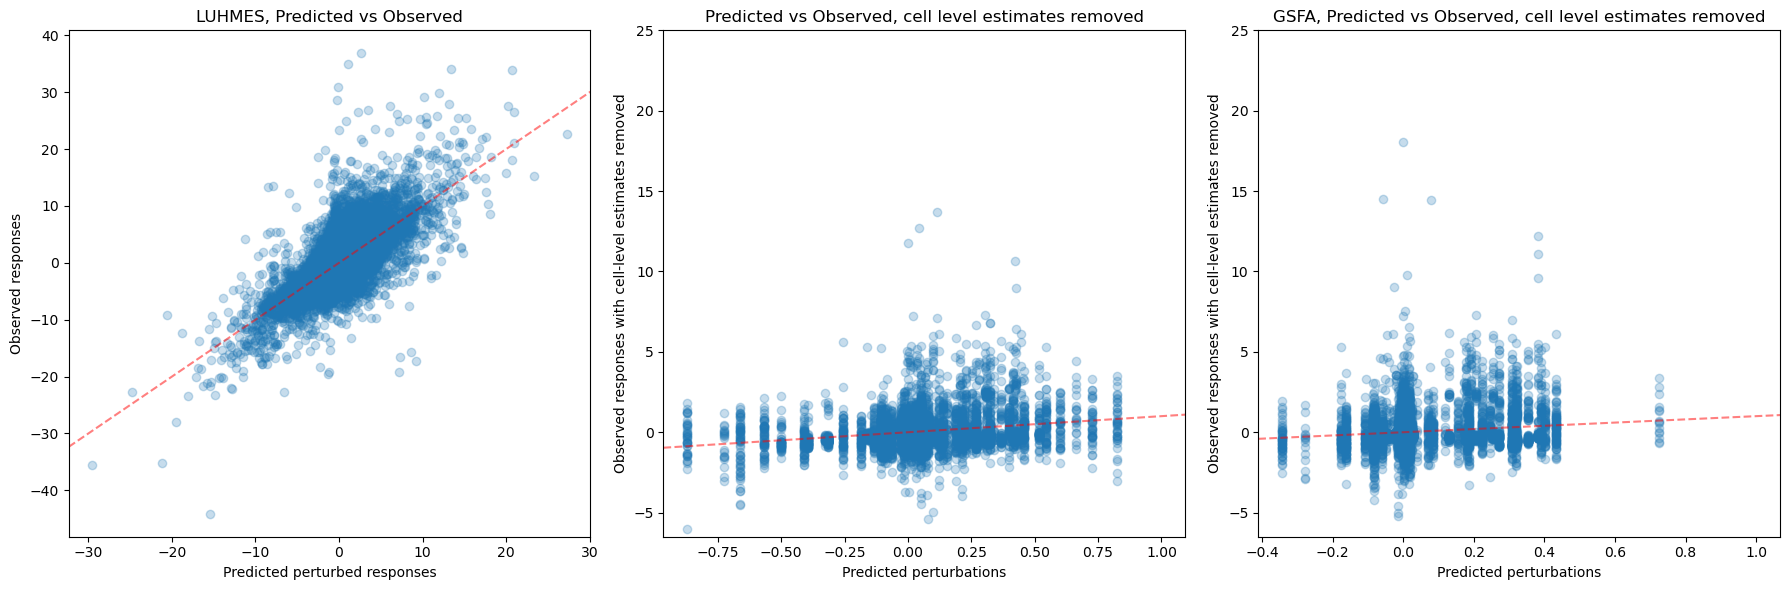

In [4]:
# computing normalized estimates from test set
fitted_vals = Gaussian_estimates(model=parametric_model, obs=my_observation[parametric_model.test_id], 
                                 cond=my_conditioner[parametric_model.test_id], cell_info=my_cell_info[parametric_model.test_id])
pert_mean_LUHMES = fitted_vals['pert_mean'].ravel() * 1.0
obs_LUHMES = fitted_vals['obs'].ravel() * 1.0
inclusion_LUHMES = fitted_vals['prob'] > threshold
normed_pert_effect_LUHMES = (fitted_vals['pert_effect'] - fitted_vals['base_removed'].mean(0)[None, :])/np.sqrt(fitted_vals['base_removed'].var(axis=0)[None, :])
normed_pert_removed_LUHMES = (fitted_vals['base_removed'] - fitted_vals['base_removed'].mean(0)[None, :])/np.sqrt(fitted_vals['base_removed'].var(axis=0)[None, :])
normed_pert_effect_LUHMES = normed_pert_effect_LUHMES[inclusion_LUHMES]
normed_pert_removed_LUHMES = normed_pert_removed_LUHMES[inclusion_LUHMES]

# load pre-computed estimates
# pert_mean_LUHMES = pd.read_csv('./GPerturb_vis_data/pert_mean_LUHMES.csv').to_numpy().ravel()
# obs_LUHMES = pd.read_csv('./GPerturb_vis_data/obs_LUHMES.csv').to_numpy().ravel()
# normed_pert_effect_LUHMES = pd.read_csv('./GPerturb_vis_data/normed_pert_effect_LUHMES.csv').to_numpy().ravel()
# normed_pert_removed_LUHMES = pd.read_csv('./GPerturb_vis_data/normed_pert_removed_LUHMES.csv').to_numpy().ravel()

# load outcomes generated by GSFA
GSFA_fit_LUHMES = pd.read_csv('./GPerturb_vis_data/GSFA_fit_LUHMES.csv').to_numpy().ravel()
GSFA_obs_LUHMES = pd.read_csv('./GPerturb_vis_data/GSFA_obs_LUHMES.csv').to_numpy().ravel()

fig, axes = plt.subplots(1,3)  # plt.subplots(nrows=2, ncols=2)
axes[0].scatter(pert_mean_LUHMES, obs_LUHMES, alpha=0.25)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Predicted perturbed responses')
axes[0].set_ylabel('Observed responses')
axes[0].set_title('LUHMES, Predicted vs Observed')

axes[1].scatter(normed_pert_effect_LUHMES,
                   normed_pert_removed_LUHMES, alpha=0.25)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_ylim(-6.5, 25)
axes[1].set_xlabel('Predicted perturbations')
axes[1].set_ylabel('Observed responses with cell-level estimates removed')
axes[1].set_title('Predicted vs Observed, cell level estimates removed')

axes[2].scatter(GSFA_fit_LUHMES, GSFA_obs_LUHMES, alpha=0.25)
axes[2].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[2].set_ylim(-6.5, 25)
axes[2].set_xlabel('Predicted perturbations')
axes[2].set_ylabel('Observed responses with cell-level estimates removed')
axes[2].set_title('GSFA, Predicted vs Observed, cell level estimates removed')

fig.set_size_inches(18, 6)
fig.tight_layout()
# plt.savefig('./GPerturb_vis/GPerturb_vs_GSFA_3_upper.png', dpi=200)

# Fig 4

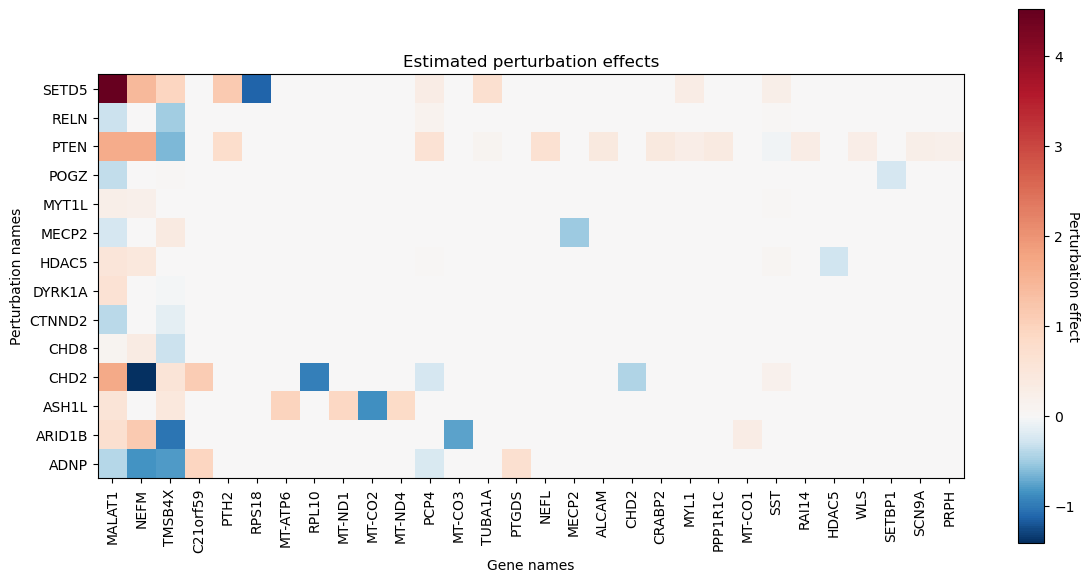

In [5]:
# Get sparse estimates of perturbation effects
unique_conditions = torch.unique(my_conditioner, dim=0)

# compute from the model
# perturb_level, _, _, _, logit_p, _, _ = parametric_model(unique_conditions, None)
# estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
# logit_p = logit_p.detach().cpu().numpy()
# perturb_level = perturb_level.detach().cpu().numpy()

# load pre-computed results
perturb_level = pd.read_csv('./GPerturb_vis_data/perturb_level_LUHMES.csv').to_numpy()
logit_p = pd.read_csv('./GPerturb_vis_data/logit_p_LUHMES.csv').to_numpy()
estimated_inclusion_prob = 1/(1+np.exp(-1*logit_p))

estimated_inclusion = estimated_inclusion_prob > threshold
deg_LUHMES_BASPR = estimated_inclusion.sum(1)
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]
top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]

unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]

estimated_pert_LUHMES = estimated_pert[1:, top_gene]*1.0
my_gene_name_LUHMES = copy.copy(my_gene_name[top_gene])
my_yticks_LUHMES = copy.copy(my_yticks[1:])


fig2, axes2 = plt.subplots(1, 1)

negatives = estimated_pert_LUHMES.min()
positives = estimated_pert_LUHMES.max()
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_LUHMES, cmap=cmap_2neg_4pos)
# im = axes2.imshow(estimated_pert_LUHMES, norm=norm, cmap='RdBu_r')
axes2.set_xticks(np.arange(len(my_gene_name_LUHMES)), my_gene_name_LUHMES, rotation=90)
axes2.set_yticks(np.arange(len(my_yticks_LUHMES)), my_yticks_LUHMES)
axes2.set_ylabel('Perturbation names')
axes2.set_xlabel('Gene names')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
# ticks = np.append(np.arange(-1.5, 0, 0.5), np.arange(0, 5.101, 1.7))
# fig2.colorbar(im, ax=axes2, ticks=ticks)
cbar = fig2.colorbar(im, ax=axes2)
cbar.ax.set_ylabel('Perturbation effect', rotation=270)
fig2.set_size_inches(12, 6)
fig2.tight_layout()
# plt.savefig('./GPerturb_vis/LUHMES_GPerturb_heatmap_4.png', dpi=300)

# Fig 5

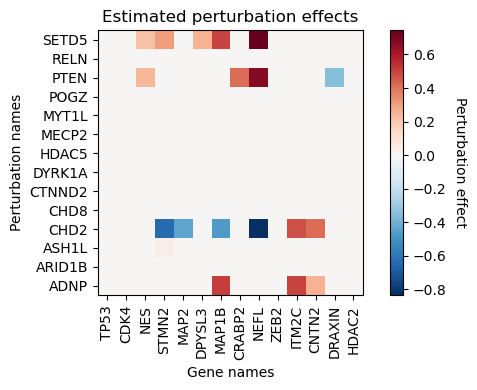

In [8]:
marker_genes = ['TP53', 'CDK4', 'NES', 'STMN2', 'MAP2', 'DPYSL3', 'MAP1B', 'CRABP2', 'NEFL', 'ZEB2', 'ITM2C', 'CNTN2', 'DRAXIN', 'HDAC2']
mean_expression_non_tar = my_observation[my_conditioner.mean(1) == 0.].mean(0)
threshold = 0.5
unique_conditions = torch.unique(my_conditioner, dim=0)
estimated_inclusion_prob = 1/(1+np.exp(-1*logit_p))
estimated_inclusion = estimated_inclusion_prob > threshold
estimated_pert = perturb_level * estimated_inclusion
estimated_pert = estimated_pert[:, [gene_name.index(i) for i in marker_genes]]

unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]

estimated_pert_LUHMES = estimated_pert[1:, ]*1.0
my_gene_name_LUHMES = copy.copy(marker_genes)
my_yticks_LUHMES = copy.copy(my_yticks[1:])


fig2, axes2 = plt.subplots(1, 1)

negatives = estimated_pert_LUHMES.min()
positives = estimated_pert_LUHMES.max()
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_LUHMES, cmap=cmap_2neg_4pos)
# im = axes2.imshow(estimated_pert_LUHMES, norm=norm, cmap='RdBu_r')
axes2.set_xticks(np.arange(len(my_gene_name_LUHMES)), my_gene_name_LUHMES, rotation=90)
axes2.set_yticks(np.arange(len(my_yticks_LUHMES)), my_yticks_LUHMES)
axes2.set_ylabel('Perturbation names')
axes2.set_xlabel('Gene names')
axes2.set_title('Estimated perturbation effects')
# ticks = np.append(np.arange(-1.5, 0, 0.5), np.arange(0, 5.101, 1.7))
# fig2.colorbar(im, ax=axes2, ticks=ticks)
cbar = fig2.colorbar(im, ax=axes2)
cbar.ax.set_ylabel('Perturbation effect', rotation=270, labelpad=15)
fig2.set_size_inches(6, 4)
fig2.tight_layout()
# plt.savefig('./GPerturb_vis/LUHMES_Gperturb_heatmap_markers_3.png', dpi=300)

# Fig 6

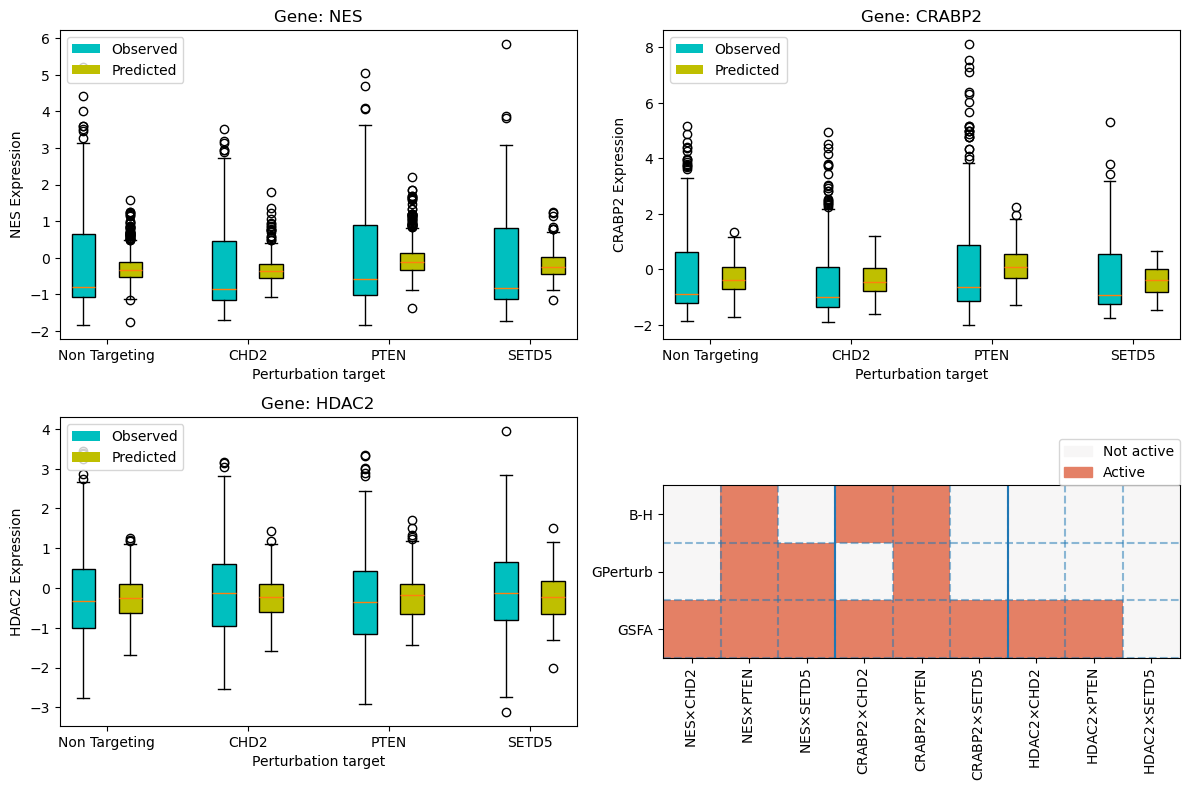

In [14]:
# fitted_vals = Gaussian_estimates(model=parametric_model, obs=my_observation, cond=my_conditioner, cell_info=my_cell_info)['pert_mean']
# load from precomputed
fitted_vals = pd.read_csv('./GPerturb_vis_data/fitted_LUHMES.csv').to_numpy()

gene_list = ['NES', 'CRABP2', 'HDAC2']
pert_1 = 'CHD2'
pert_2 = 'PTEN'
pert_3 = 'SETD5'

unique_conditions = torch.unique(my_conditioner, dim=0)
unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]
pret_id_1 = cond_name.index(pert_1)
pret_id_2 = cond_name.index(pert_2)
pret_id_3 = cond_name.index(pert_3)

color = ['c', 'y', 'c', 'y', 'c', 'y', 'c', 'y']
import matplotlib.patches as mpatches
f, a = plt.subplots(ncols=2, nrows=2)
pvals=np.zeros(0)
for idx, i in enumerate(gene_list):
    CHD2_pert = my_observation[my_conditioner[:, pret_id_1] == 1., gene_name.index(i)].numpy()
    CHD2_pert_est = fitted_vals[my_conditioner[:, pret_id_1] == 1., gene_name.index(i)]

    PTEN_pert = my_observation[my_conditioner[:, pret_id_2] == 1., gene_name.index(i)].numpy()
    PTEN_pert_est = fitted_vals[my_conditioner[:, pret_id_2] == 1., gene_name.index(i)]

    SETD5_pert = my_observation[my_conditioner[:, pret_id_3] == 1., gene_name.index(i)].numpy()
    SETD5_pert_est = fitted_vals[my_conditioner[:, pret_id_3] == 1., gene_name.index(i)]

    base = my_observation[my_conditioner.mean(1) == 0., gene_name.index(i)].numpy()
    base_est = fitted_vals[my_conditioner.mean(1) == 0., gene_name.index(i)]

    pvals = np.concatenate((pvals, np.array([stats.ttest_ind(CHD2_pert, base, equal_var=False)[1],
                                   stats.ttest_ind(PTEN_pert, base, equal_var=False)[1],
                                   stats.ttest_ind(SETD5_pert, base, equal_var=False)[1]])))
    pos = [1, 2, 4, 5, 7, 8, 10, 11]
    label = ['Non Targeting', 'CHD2', 'PTEN', 'SETD5']
    data = [base, base_est, CHD2_pert, CHD2_pert_est, PTEN_pert, PTEN_pert_est, SETD5_pert, SETD5_pert_est]
    bxp = a[idx//2, idx%2].boxplot(data, positions=pos, patch_artist = True)
    a[idx//2, idx%2].set_xticks(ticks=[1.5, 4.5, 7.5, 10.5], labels=label)
    a[idx//2, idx%2].set_title('Gene: ' + i)
    a[idx//2, idx%2].set_ylabel(i + ' Expression')
    a[idx//2, idx%2].set_xlabel('Perturbation target')
    legend_elements = [mpatches.Patch(facecolor=color[0], label='Observed'),
                       mpatches.Patch(facecolor=color[1], label='Predicted')]
    for boxes, colo in zip(bxp['boxes'], color):
        boxes.set_facecolor(colo)
    a[idx//2, idx%2].legend(handles = legend_elements, loc='upper left')

adj_p = 1.0*(stats.false_discovery_control(pvals)<0.05)
BSAPR = np.array([0,1,1,0,1,0,0,0,0])
GSFA = np.array([1,1,1,1,1,1,1,1,0])
im=a[1,1].imshow(np.array([adj_p, BSAPR, GSFA]), cmap='RdBu_r', vmax=2, vmin=-2)
a[1,1].set_xticks(np.arange(9), [i + r'$\times$' + j for i in gene_list for j in [pert_1, pert_2, pert_3]], rotation=90)
a[1,1].set_yticks(np.arange(3), ['B-H', 'GPerturb', 'GSFA'])
a[1,1].axvline(x=2.5)
a[1,1].axvline(x=5.5)
for i in range(8):
    a[1, 1].axvline(x=i + .5, alpha=0.5, linestyle='--')
for i in range(3):
    a[1, 1].axhline(y=i + .5, alpha=0.5, linestyle='--')

a[1,1].grid(linestyle='--', linewidth=1., which='minor')
values=np.array([0,1])
l = ['Not active', 'Active']
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color
patches = [ mpatches.Patch(color=colors[i], label=l[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1., 1), loc=4, borderaxespad=0. )

f.set_size_inches(12, 8)
f.tight_layout()
# plt.savefig('./GPerturb_vis/LUHMES_box_3.png', dpi=300)